In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
# https://avandekleut.github.io/vae/

In [3]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
batch_size = 128

In [6]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=batch_size,
        shuffle=True)

In [7]:
class ConvLayerNorm(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding):
        super(ConvLayerNorm, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, ks, stride, padding),  
            nn.BatchNorm2d(ch_out),
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)
    
    
class ConvLayer(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding):
        super(ConvLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, ks, stride, padding),  
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)
    
    
    
class ConvTransposeLayer(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, paddingm, output_padding=0):
        super(ConvTransposeLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, ks, stride, 
                               padding=padding, output_padding=output_padding),
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)

    
class ConvTransposeLayerNorm(nn.Module):
    def __init__(self, ch_in, ch_out, ks, stride, padding, output_padding=0):
        super(ConvTransposeLayerNorm, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, ks, stride, 
                               padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(ch_out),
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)

In [8]:
class Encoder(nn.Module):
    def __init__(self, nchannels):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            ConvLayerNorm(nchannels, 4, ks=3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=1),  
            ConvLayerNorm(4, 8, ks=3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=0),  
            ConvLayerNorm(8, 8, ks=3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=0),  
            
            
#             ConvLayerNorm(nchannels, 4, ks=3, stride=2, padding=1),
#             ConvLayerNorm(4, 8, ks=3, stride=2, padding=0),
#             ConvLayerNorm(8, 8, ks=3, stride=2, padding=0),
        )

    def forward(self, x):
        return self.encoder(x)

In [9]:
x, y = next(iter(data))
z = Encoder(1)(x)
z.shape

torch.Size([128, 8, 2, 2])

In [10]:
class Decoder(nn.Module):
    def __init__(self, nchannels):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            ConvTransposeLayerNorm(8, 8, 3, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 5, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 5, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 5, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 5, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 8, 5, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(8, 4, 3, stride=1, padding=0, output_padding=0),
            ConvTransposeLayerNorm(4, nchannels, 3, stride=1, padding=0, output_padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)
    
    

In [11]:
Decoder(1)(z).shape

torch.Size([128, 1, 28, 28])

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, nchannels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(nchannels)
        self.decoder = Decoder(nchannels)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [13]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [14]:
autoencoder = Autoencoder(nchannels=1).to(device) # GPU
autoencoder = train(autoencoder, data, epochs=20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.74s/it]


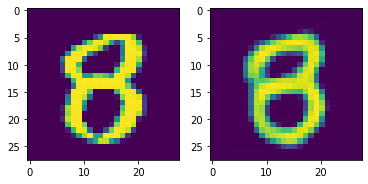

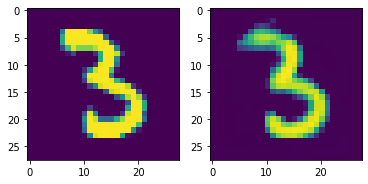

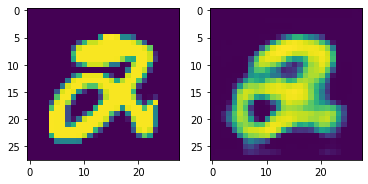

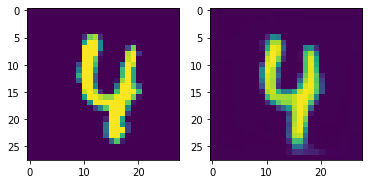

In [15]:
x, y = next(iter(data))
z = autoencoder(x.to(device))

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    # Reshape the array for plotting
    plt.sca(ax[0])
    plt.imshow(x[i].reshape(-1, 28, 28)[0].cpu().detach().numpy())
    
    plt.sca(ax[1])
    plt.imshow(z[i].reshape(28, 28).cpu().detach().numpy())

In [16]:
outputs = np.zeros([0, 32])
labels = np.zeros(0)
autoencoder.eval()
for x, y in data:
    z = autoencoder.encoder(x.to(device))
    z = z.reshape((len(z), -1))
    outputs = np.concatenate([outputs, z.cpu().detach().numpy()], axis=0)
    labels = np.concatenate([labels, y])

In [17]:
outputs.shape

(60000, 32)

In [18]:
tsne = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(outputs[:10000])

In [19]:
import matplotlib.patheffects as PathEffects
def fashion_scatter(x, colors):
    """
    https://www.datacamp.com/community/tutorials/introduction-t-sne
    """
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

/tmp/ipykernel_1443820/3406033206.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-47.23074, -49.728798, '0'),
  Text(-0.2958496, 69.768974, '1'),
  Text(-8.1603775, -24.939903, '2'),
  Text(-53.423264, 14.526295, '3'),
  Text(50.321213, -9.737255, '4'),
  Text(-26.460175, 19.89251, '5'),
  Text(9.629216, -64.67857, '6'),
  Text(47.989998, 35.004475, '7'),
  Text(-22.222618, 11.623057, '8'),
  Text(47.13873, -8.759127, '9')])

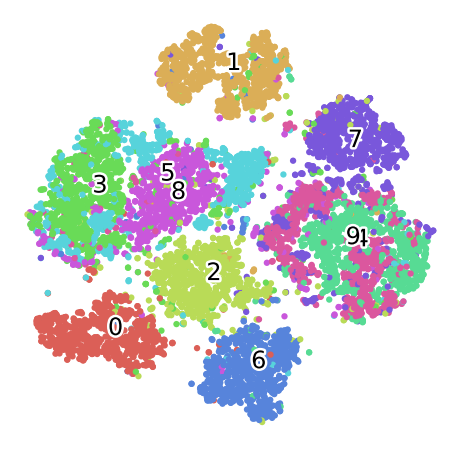

In [20]:
fashion_scatter(tsne, labels[:10000])